In [32]:
import numpy as np

In [33]:
fisher = np.load('data/realfisher_10_False.npy')
summary = np.load('data/realsummary_10_False.npy')
lhd_summary = np.load('data/lhd_summaries_10_False.npy')
thetas = np.load('data/theta_lhd_10_False.npy')

In [34]:
fisher

array([[4446108.5, 1470053.6],
       [1470053.6, 1944223.9]], dtype=float32)

In [35]:
w, v  = np.linalg.eig(fisher)
print (w)
print (v)

covsum = np.cov(lhd_summary,rowvar=False)
wcov, vcov = np.linalg.eig(covsum)

print()
print (wcov)
print (vcov)

[5125429.  1264903.4]
[[ 0.9077633  -0.41948277]
 [ 0.41948277  0.9077633 ]]
()
[ 0.01948171 10.4530883 ]
[[-0.92006413  0.39176778]
 [-0.39176778 -0.92006413]]


In [36]:
print (np.dot(v, summary.T))
print ()
print (np.dot(v.T,np.dot(fisher,v)))

[[-133.38474]
 [ 119.41726]]
()
[[5.1254290e+06 9.3750000e-02]
 [0.0000000e+00 1.2649035e+06]]


In [37]:
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/software/local/lib64/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['axes', 'cov']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


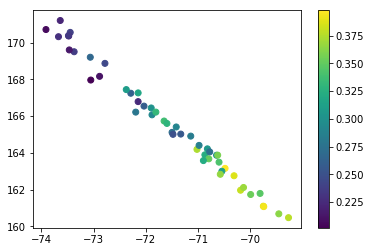

In [38]:
plt.scatter(lhd_summary[:,0], lhd_summary[:,1], c = thetas[:,0])
plt.colorbar()

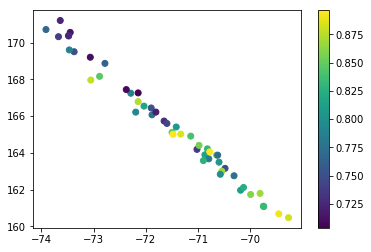

In [39]:
plt.scatter(lhd_summary[:,0], lhd_summary[:,1], c = thetas[:,1])
plt.colorbar()

In [40]:
new_lhd_summary = np.zeros_like(lhd_summary)
new_lhd_summary_cov = np.zeros_like(lhd_summary)

In [41]:
for i in range(len(lhd_summary)):
    new_lhd_summary[i,:] = np.dot(v.T, lhd_summary[i,:])
    new_lhd_summary_cov[i,:] = np.dot(vcov.T, lhd_summary[i,:])

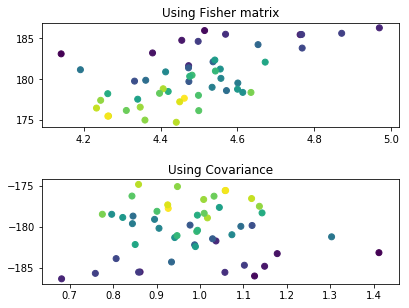

In [42]:
fig, axes = plt.subplots(2,1, figsize=(6.4,4.8))
plt.subplots_adjust(hspace=0.5)
plt.sca(axes[0])
plt.title("Using Fisher matrix")
plt.scatter(new_lhd_summary[:,0], new_lhd_summary[:,1]
            , c = thetas[:,0])
plt.sca(axes[1])
plt.title("Using Covariance")
plt.scatter(new_lhd_summary_cov[:,0], new_lhd_summary_cov[:,1]
            , c = thetas[:,0])
plt.savefig('./summaries_10_transformed.png')
plt.show()

In [43]:
np.cov(new_lhd_summary,rowvar=False)

array([[ 0.02907252,  0.31618594],
       [ 0.31618594, 10.44349916]])

In [44]:
np.dot(v.T, v)

array([[1., 0.],
       [0., 1.]], dtype=float32)

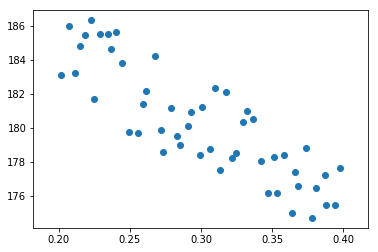

In [45]:
plt.scatter(thetas[:,0], new_lhd_summary[:,1])

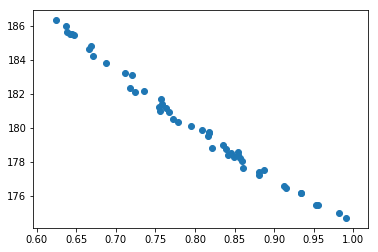

In [46]:
plt.scatter(thetas[:,1]*(thetas[:,0]/0.3)**.5, new_lhd_summary[:,1])

In [47]:
import george

In [48]:
from george import kernels

In [49]:
y = new_lhd_summary[:,1]
t = thetas.copy()
t[:,1] = t[:,1]*(t[:,0]/0.3)**.5

In [50]:
kernel = 100.*kernels.ExpSquaredKernel(20.0 , ndim = 2)

In [51]:
gp = george.GP(kernel, mean=np.mean(y), fit_mean=True)

In [52]:
gp.compute(t)

In [53]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    ll = gp.lnlikelihood(y, quiet=True)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    # Update the kernel parameters and compute the likelihood.
    gp.set_parameter_vector(p)
    return -gp.grad_lnlikelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(t)

# Print the initial ln-likelihood.
print(gp.lnlikelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
print p0
results = op.minimize(nll, p0, jac=grad_nll)
print results.x
# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.lnlikelihood(y))


-10885651115.043774
[180.26257324   3.91202301   2.99573227]
[180.26257313   4.20119567   2.02801374]
-9912875071.577133


In [54]:
t0, t1 = np.linspace(0.2,0.4, 20), np.linspace(0.6,1.0, 20)
tnew = np.meshgrid(t0,t1)
# tnew is (400,2)
tnew = np.array(tnew).reshape(2,-1).T
tt0, tt1 = np.meshgrid(t0,t1)

In [55]:
mu, cov = gp.predict(y, tnew)

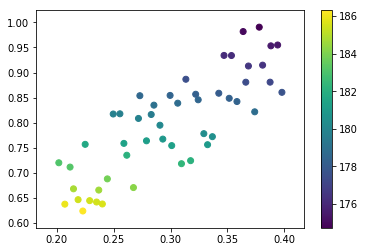

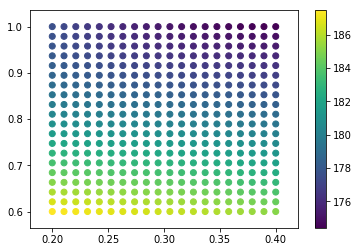

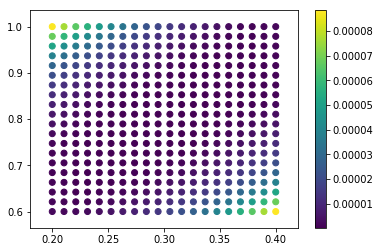

In [56]:
plt.scatter(t[:,0], t[:,1] , c = y)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(tt0.flatten(), tt1.flatten(), c = mu)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(tt0.flatten(), tt1.flatten(), c = np.diag(cov)**.5)
plt.colorbar()
plt.show()
plt.close()

In [57]:
mu_old, cov = gp.predict(y, t)

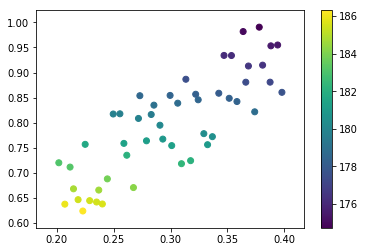

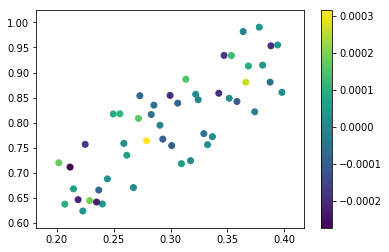

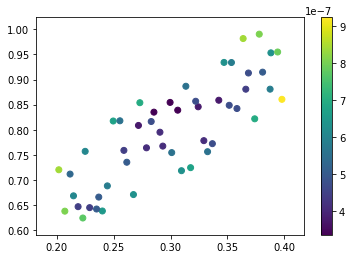

In [58]:
plt.scatter(t[:,0], t[:,1] , c = y)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(t[:,0], t[:,1] , c = (y-mu_old)/y)
plt.colorbar()
plt.show()
plt.close()

plt.scatter(t[:,0], t[:,1] , c = np.diag(cov)**.5)
plt.colorbar()
plt.show()
plt.close()

In [59]:
tnew.shape

(400, 2)

In [60]:
tnew = np.array([0.3,0.8]).reshape(1,2)

In [61]:
mu, cov = gp.predict(y, tnew)
print mu

[179.90905751]


In [62]:
#http://www.gaussianprocess.org/gpml/chapters/RW2.pdf